# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: José Juan Díaz Campos

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from jjodiaz.spark_utils import SparkUtils
from pyspark.sql.functions import get_json_object, col

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("local[*]") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 14:59:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/26 14:59:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/09/26 14:59:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/09/26 14:59:38 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/09/26 14:59:38 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


## Leer los csv

In [2]:
schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")

schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")

schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")

schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")

schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")

## Hacer el join

In [3]:
final_result = df_rentals \
    .withColumn("car_id", get_json_object(col("rental_info"), "$.car_id").cast("int")) \
    .withColumn("customer_id", get_json_object(col("rental_info"), "$.customer_id").cast("int")) \
    .withColumn("agency_id", get_json_object(col("rental_info"), "$.agency_id").cast("int")) \
    .join(
        df_cars.withColumn("car_name", get_json_object(col("car_info"), "$.car_name")),
        "car_id", 
        "inner"
    ) \
    .join(
        df_customers.withColumn("customer_name", get_json_object(col("customer_info"), "$.customer_name")),
        "customer_id", 
        "inner"
    ) \
    .join(
        df_agencies.withColumn("agency_name", get_json_object(col("agency_info"), "$.agency_name")),
        "agency_id", 
        "inner"
    ) \
    .select(
        col("rental_id"),
        col("car_name"),
        col("agency_name"),
        col("customer_name")
    ) \
    .orderBy("rental_id")


In [4]:
final_result.show(20, truncate=False)

+---------+------------------------------------+-------------+----------------+
|rental_id|car_name                            |agency_name  |customer_name   |
+---------+------------------------------------+-------------+----------------+
|0        |Grimes-Green Model 8                |SF Cars      |Laura Perry     |
|1        |Wallace-Carlson Model 9             |SF Cars      |Melanie Patrick |
|2        |Wagner LLC Model 1                  |NYC Rentals  |Theresa Estrada |
|3        |Bolton, Burns and Turner Model 10   |LA Car Rental|Amanda Garcia   |
|4        |Alvarez-Davis Model 3               |SF Cars      |Corey Cook      |
|5        |Grimes-Green Model 8                |SF Cars      |Kyle Ramos      |
|6        |Grimes-Green Model 8                |NYC Rentals  |Julie Chen      |
|7        |Clayton-Cook Model 10               |LA Car Rental|Sarah Peterson  |
|8        |Garcia, Hamilton and Carr Model 5   |SF Cars      |Jay Walsh       |
|9        |Chang-Fisher Model 7         

## pt2: lo de la clase del viernes

### código del profe:

In [5]:
agencies_schema = SparkUtils.generate_schema([("agency_id", "string"), ("agency_info", "string")])
cars_schema = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
customers_schema = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
rental_cars_schema = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

base_path = "/opt/spark/work-dir/data/"

agencies_df = spark.read \
                .schema(agencies_schema) \
                .option("header", "true") \
                .csv(base_path + "car_service/agencies")
agencies_df = agencies_df.withColumn("agency_name", get_json_object(agencies_df.agency_info, "$.agency_name"))


cars_df = spark.read.option("header", "true").schema(cars_schema).csv(base_path + "car_service/cars")

brands_df = spark.read.option("header", "true").schema(cars_schema).csv(base_path + "car_service/brands")

customers_df = spark.read.option("header", "true").schema(customers_schema).csv(base_path + "car_service/customers")

rental_cars_df = spark.read.option("header", "true").schema(rental_cars_schema).csv(base_path + "car_service/rentals")
agencies_df = agencies_df.withColumn("agency_name", get_json_object(agencies_df.agency_info, "$.agency_name")).drop("agency_info")
cars_df = cars_df.withColumn("car_name", get_json_object(cars_df.car_info, "$.car_name")).drop("car_info")
customers_df = customers_df.withColumn("customer_name", get_json_object(customers_df.customer_info, "$.customer_name")).drop("customer_info")

rental_cars_df = rental_cars_df.withColumn("car_id", get_json_object(rental_cars_df.rental_info, '$.car_id')) \
                            .withColumn("customer_id", get_json_object(rental_cars_df.rental_info, '$.customer_id')) \
                            .withColumn("agency_id", get_json_object(rental_cars_df.rental_info, '$.agency_id')) \
                            .drop("rental_info")
rental_cars_df = rental_cars_df.join(cars_df, on="car_id", how="left") \
                                .join(customers_df, on="customer_id", how="left") \
                                .join(agencies_df, on="agency_id", how="left") \
                                .drop("agency_id", "customer_id", "car_id")

rental_cars_df.show(5)


+---------+--------------------+---------------+-------------+
|rental_id|            car_name|  customer_name|  agency_name|
+---------+--------------------+---------------+-------------+
|    11891|Wallace-Carlson M...| Margaret Jones|  NYC Rentals|
|    11892|Grimes-Green Model 8|Albert Williams|LA Car Rental|
|    11893|Stewart-Allen Mod...|  Caleb Fleming|      SF Cars|
|    11894|  Campos PLC Model 4|  Andrew Butler|  NYC Rentals|
|    11895|  Wagner LLC Model 1|  Kristin Potts|      SF Cars|
+---------+--------------------+---------------+-------------+
only showing top 5 rows


# Persist Data
## Parquet file

In [6]:
!pwd

/opt/spark/work-dir/labs/lab04


In [10]:
!du -sh ../../data/car_service/rentals/

1.1M	../../data/car_service/rentals/


In [8]:
rental_cars_df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")

In [9]:
!ls {base_path}car_service/output/parquet/

!du -sh {base_path}car_service/output/parquet/

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'
224K	/opt/spark/work-dir/data/car_service/output/parquet/


## POWER-BI Dashboard Examples
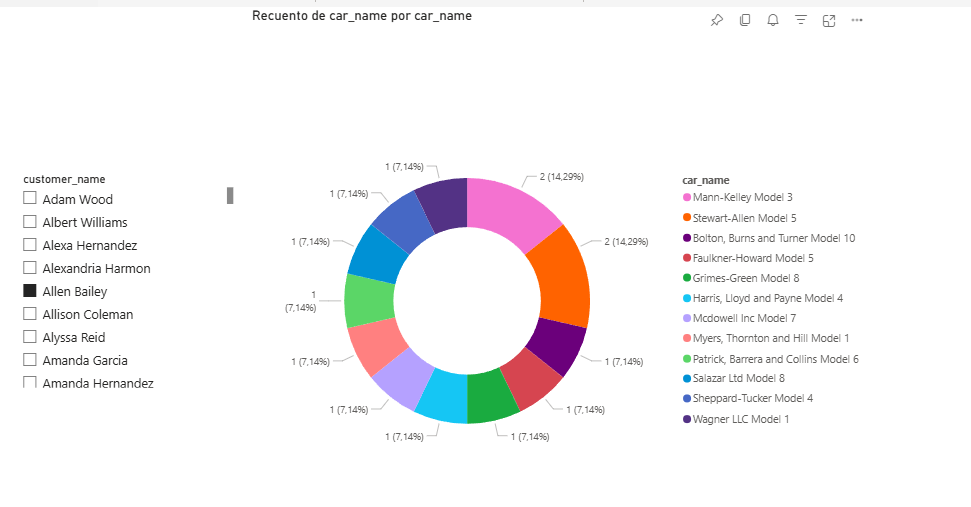

In [ ]:
sc.stop()